In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, SubsetRandomSampler, Subset, WeightedRandomSampler
import torchvision
from torch.autograd import Variable
from torchvision.datasets import ImageFolder, DatasetFolder
import torchvision.transforms as transforms
from sklearn.metrics import confusion_matrix, classification_report
import os
import seaborn as sns

import PIL
from PIL import Image
import warnings
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [2]:
image_transforms = transforms.Compose(
                   [transforms.Resize((32,32)),
                    transforms.ToTensor(),
                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [3]:
MAIN = '../input/face-mask-dataset/data'

In [4]:
dataset = ImageFolder(
                      root = MAIN,
                      transform = image_transforms
                       )
dataset

Dataset ImageFolder
    Number of datapoints: 7553
    Root location: ../input/face-mask-dataset/data
    StandardTransform
Transform: Compose(
               Resize(size=(32, 32), interpolation=PIL.Image.BILINEAR)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

# Reordering Classes

In [5]:
dataset.class_to_idx

dataset.class_to_idx = {'with_mask':1, 'without_mask':0}
dataset.class_to_idx

{'with_mask': 1, 'without_mask': 0}

In [6]:
idx2class = {v: k for k, v in dataset.class_to_idx.items()}
idx2class

{1: 'with_mask', 0: 'without_mask'}

In [7]:
def get_class_distribution(dataset_obj):
    count_dict = {k:0 for k,v in dataset_obj.class_to_idx.items()}
    
    for element in dataset_obj:
        y_lbl = element[1]
        y_lbl = idx2class[y_lbl]
        count_dict[y_lbl] += 1
            
    return count_dict
print("Distribution of classes: \n", get_class_distribution(dataset))

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:961: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Distribution of classes: 
 {'with_mask': 3828, 'without_mask': 3725}


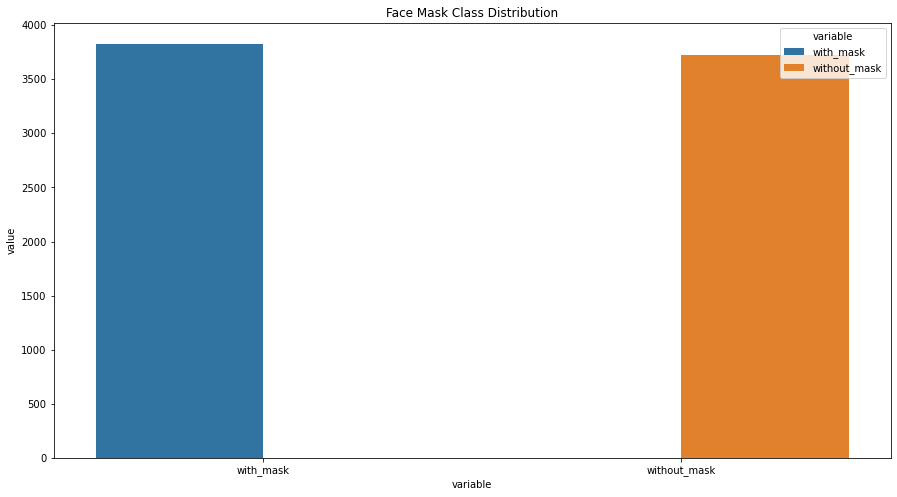

In [8]:
plt.figure(figsize=(15,8))
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(dataset)]).melt(), x = "variable", y="value", hue="variable").set_title('Face Mask Class Distribution')
plt.show()

# Splitting into Train and Validation Set

In [9]:
train_dataset, val_dataset = random_split(dataset, (6000, 1553))

In [10]:
train_loader = DataLoader(dataset=train_dataset, shuffle=True, batch_size=4, num_workers=2)
val_loader = DataLoader(dataset=val_dataset, shuffle=False, batch_size=4, num_workers=2)
print("Length of the train_loader:", len(train_loader))
print("Length of the val_loader:", len(val_loader))

Length of the train_loader: 1500
Length of the val_loader: 389


## Random few images

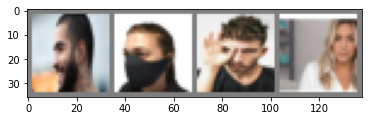

without_mask with_mask without_mask without_mask


In [11]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
classes = ('with_mask', 'without_mask')
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

# Defining Neural Network

In [12]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()

In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# Training Neural Network

In [14]:
def images_to_probs(net, images):
    output = net(images)
    # convert output probabilities to predicted class
    _, preds_tensor = torch.max(output, 1)
    preds = np.squeeze(preds_tensor.numpy())
    return preds, [F.softmax(el, dim=0)[i].item() for i, el in zip(preds, output)]

def evaluate(net, dataloader):
    correct, total = 0, 0
    with torch.no_grad():
        net.eval()
        for images, labels in dataloader:
            images, labels = images, labels.numpy()

            preds, probs = images_to_probs(net, images)

            total += len(labels)
            correct += (preds == labels).sum()
    return correct/total * 100

from tqdm.notebook import tqdm

def train(net, loss_fn, opt, dataloader, epochs):
    num_steps = 0
    min_loss = 1e+10

    for epoch in tqdm(range(1, epochs+1), total=epochs, desc='Training'):
        running_loss = []
        net.train() # Setting the network to TRAIN mode
        for images, labels in dataloader:
            images, labels = images, labels
            num_steps += 1

            # FP
            outs = net(images)
            loss = loss_fn(outs, labels)

            # Logging the loss value
            running_loss.append(loss.item())

            # BP
            opt.zero_grad()
            loss.backward()
            opt.step()

            # Clearing the RAM
            #del images, labels, outs
            #torch.device('cpu').empty_cache()
        
        epoch_loss = sum(running_loss) / len(running_loss)
        acc = evaluate(net, dataloader)
        print("Accuracy: ",acc)
        print("loss: ",epoch_loss)
        # Model Checkpointing
        if epoch_loss < min_loss:
            min_loss = epoch_loss
            bestmodel = net.state_dict()
    #torch.save(bestmodel,'{0}_{1:0.4f}.pth'.format('classifier',min_loss))
    return None

    print('Training finished!!!')

In [15]:
train(net, criterion, optimizer, train_loader, 2)

Accuracy:  87.94999999999999
loss:  0.6438769178089375
Accuracy:  90.31666666666666
loss:  0.25736804123488644



# Testing Neural Network

In [16]:
testimg, testlab = next(iter(val_loader))
testimg, testlab = testimg, testlab

pred = net(testimg)
predlab = torch.argmax(pred,axis=1)

In [17]:
print("Predicted",[i for i in predlab])
print("Actual",[i for i in testlab])
for i in predlab:
  if i == 0:
    print("without_mask")
  else:
    print("with_mask")
print("______________________________________________________________________________________________________________")
for i in testlab:
  if i == 0:
    print("without_mask")
  else:
    print("with_mask")

Predicted [tensor(0), tensor(1), tensor(0), tensor(1)]
Actual [tensor(0), tensor(1), tensor(0), tensor(1)]
without_mask
with_mask
without_mask
with_mask
______________________________________________________________________________________________________________
without_mask
with_mask
without_mask
with_mask


Currently learning how to do it for the whole validation set. Since batch_size = 4, we get this output.

# Final Metrics

## Confusion Matrix

In [18]:
predlab = predlab.to(torch.device('cpu'))
testlab = testlab.to(torch.device('cpu'))
pred = predlab.numpy()
test = testlab.numpy()
matrix = confusion_matrix(test,pred)
print(matrix)

[[2 0]
 [0 2]]


# Classification Report

In [19]:
report = classification_report(test, pred, target_names=['with_mask','without_mask'])
print(report)  

              precision    recall  f1-score   support

   with_mask       1.00      1.00      1.00         2
without_mask       1.00      1.00      1.00         2

    accuracy                           1.00         4
   macro avg       1.00      1.00      1.00         4
weighted avg       1.00      1.00      1.00         4



# Data Parallelism

In [20]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()

In [21]:
if torch.cuda.device_count() > 1:
    print(torch.cuda.device_count())
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    net = nn.DataParallel(net)

net = net.to(device)

2
Let's use 2 GPUs!


In [22]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [23]:
def images_to_probs(net, images):
    images = images.to(device)  # Move images to the same device as the network
    output = net(images)
    _, preds_tensor = torch.max(output, 1)
    preds = np.squeeze(preds_tensor.cpu().numpy())  # Move tensor to CPU before converting to NumPy
    return preds, [F.softmax(el, dim=0)[i].item() for i, el in zip(preds, output)]


def evaluate(net, dataloader):
    correct, total = 0, 0
    with torch.no_grad():
        net.eval()
        for images, labels in dataloader:
            images, labels = images, labels.numpy()

            preds, probs = images_to_probs(net, images)

            total += len(labels)
            correct += (preds == labels).sum()
    return correct/total * 100

from tqdm.notebook import tqdm


def train(net, loss_fn, opt, dataloader, epochs):
    num_steps = 0
    min_loss = 1e+10

    for epoch in tqdm(range(1, epochs+1), total=epochs, desc='Training'):
        running_loss = []
        net.train() # Setting the network to TRAIN mode
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)  # Move tensors to the same device

            num_steps += 1

            # FP
            outs = net(images)
            loss = loss_fn(outs, labels)

            # Logging the loss value
            running_loss.append(loss.item())

            # BP
            opt.zero_grad()
            loss.backward()
            opt.step()

            # Clearing the RAM
            #del images, labels, outs
            #torch.device('cpu').empty_cache()
        
        epoch_loss = sum(running_loss) / len(running_loss)
        acc = evaluate(net, dataloader)
        print("Accuracy: ", acc)
        print("Loss: ", epoch_loss)
        # Model Checkpointing
        if epoch_loss < min_loss:
            min_loss = epoch_loss
            bestmodel = net.state_dict()
    #torch.save(bestmodel,'{0}_{1:0.4f}.pth'.format('classifier',min_loss))
    return None

    print('Training finished!!!')



In [24]:
train(net, criterion, optimizer, train_loader, 2)

Accuracy:  86.55000000000001
Loss:  0.6147194938448568
Accuracy:  90.16666666666666
Loss:  0.28230729094271856



In [25]:
testimg, testlab = next(iter(val_loader))
testimg, testlab = testimg, testlab

pred = net(testimg)
predlab = torch.argmax(pred,axis=1)

In [26]:
print("Predicted",[i for i in predlab])
print("Actual",[i for i in testlab])
for i in predlab:
  if i == 0:
    print("without_mask")
  else:
    print("with_mask")
print("______________________________________________________________________________________________________________")
for i in testlab:
  if i == 0:
    print("without_mask")
  else:
    print("with_mask")

Predicted [tensor(0, device='cuda:0'), tensor(1, device='cuda:0'), tensor(0, device='cuda:0'), tensor(1, device='cuda:0')]
Actual [tensor(0), tensor(1), tensor(0), tensor(1)]
without_mask
with_mask
without_mask
with_mask
______________________________________________________________________________________________________________
without_mask
with_mask
without_mask
with_mask


In [27]:
predlab = predlab.to(torch.device('cpu'))
testlab = testlab.to(torch.device('cpu'))
pred = predlab.numpy()
test = testlab.numpy()
matrix = confusion_matrix(test,pred)
print(matrix)

[[2 0]
 [0 2]]


In [28]:
report = classification_report(test, pred, target_names=['with_mask','without_mask'])
print(report)  

              precision    recall  f1-score   support

   with_mask       1.00      1.00      1.00         2
without_mask       1.00      1.00      1.00         2

    accuracy                           1.00         4
   macro avg       1.00      1.00      1.00         4
weighted avg       1.00      1.00      1.00         4

